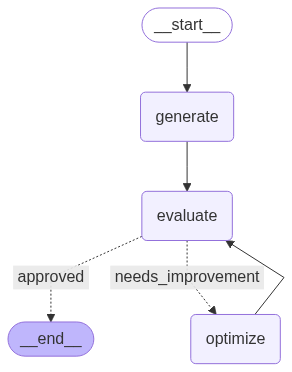

In [65]:
from IPython.display import Image
Image('X_workflow.png')

In [66]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
import operator

In [67]:
load_dotenv()

True

In [68]:
generator_model=ChatGoogleGenerativeAI(model='gemini-2.5-flash')
optimize_model=ChatGoogleGenerativeAI(model='gemini-2.5-flash')
evaluation_model=ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [69]:
# model testing
generator_model.invoke('hy').content

'Hi there! How can I help you today?'

In [70]:
# define state of the graph; 

class XState(TypedDict): 
    topic: str
    tweet: str

    evaluation: Literal['approved', 'need_improvements'] 
    feedback: str

    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [71]:
class EvalSchema(BaseModel): 
    evaluation: Literal["approved", "need_improvements"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

struct_evaluation_model=evaluation_model.with_structured_output(EvalSchema)

In [72]:
def tweet_generator(state: XState): 

    # prompt
    prompt = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
        Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
        """)
            ]

    tweet=generator_model.invoke(prompt).content

    return {'tweet': tweet, 'tweet_history': [tweet]}

In [73]:
def tweet_evaluator(state: XState): 

    # prompt
    prompt = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
            Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality – Is this fresh, or have you seen it a hundred times before?  
            2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness – Is it short, sharp, and scroll-stopping?  
            4. Virality Potential – Would people retweet or share it?  
            5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"  
            - feedback: One paragraph explaining the strengths and weaknesses 
            """)
            ]

    response=struct_evaluation_model.invoke(prompt)

    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}
    

In [74]:
def cheak_condition(state: XState): 
    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']: 
        return 'approved'
    else: 
        return 'need_improvements'


In [75]:
def tweet_optimizer(state: XState): 

    prompt = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """)
        ]

    response = optimize_model.invoke(prompt).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [76]:
# define graph: 
graph=StateGraph(XState)


# add nodes; 
graph.add_node('tweet_generator', tweet_generator)
graph.add_node('tweet_evaluator', tweet_evaluator)
graph.add_node('tweet_optimizer', tweet_optimizer)


# add edges: 
graph.add_edge(START, 'tweet_generator')
graph.add_edge('tweet_generator', 'tweet_evaluator')
graph.add_conditional_edges('tweet_evaluator', cheak_condition, {'approved': END, 'need_improvements': 'tweet_optimizer'})

graph.add_edge('tweet_optimizer', 'tweet_evaluator')


# defined workflow: 
workflow=graph.compile()

In [77]:
initial_state = {
    "topic": "sex",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [78]:
result

{'topic': 'sex',
 'tweet': 'Sex: An elaborate, full-body negotiation to decide whose turn it is to call customer service.',
 'evaluation': 'approved',
 'feedback': 'This tweet is genuinely original, offering a fresh and humorous take on relationship dynamics. Its concise and punchy delivery makes it highly scroll-stopping and gives it strong virality potential. The format is excellent, adhering to all tweet best practices without falling into common pitfalls like Q&A or setup-punchline structures, making it a well-crafted piece of content.',
 'iteration': 3,
 'max_iteration': 5,
 'tweet_history': ['Sex is just a complicated way to decide whose turn it is to get up and turn off the light.',
  'Here are a few options, aiming for sharper humor and a more unexpected twist:\n\n**Option 1 (Focus on the \'negotiation\' aspect):**\nSex: An elaborate, full-body negotiation to decide whose turn it is to call customer service.\n\n**Option 2 (More absurd, relatable chore):**\nSex: The world\'s mos

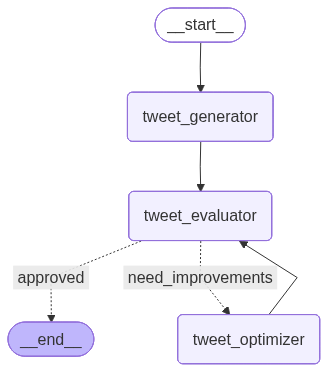

In [79]:
workflow